## V3.2

This version trains
all (187) songs that was in the format of 16th note

v3:

- Oneshot training without generator
- Normalise tempo

v3.1:
- Detected too many empty array.
- Removed them before training
- increase the sequence length to 100

copy2:
- Remove sequence that only have 1 unique value

v3.2:
- Remove seq that stay the same for input and output
- Result wasn't so positive


In [1]:
!pip install pretty_midi
!pip install keras_self_attention
!pip install music21

Processing /home/jovyan/.cache/pip/wheels/b9/ef/f5/9f35c0da899320e8f443f44ecbfa3a6721a4c3eacccad39844/pretty_midi-0.2.9-py3-none-any.whl
  Using cached mido-1.2.9-py2.py3-none-any.whl (52 kB)
Processing /home/jovyan/.cache/pip/wheels/a5/50/dd/05f616948b8bea4ff7f80632eada83ff18b6ec5d078470523e/keras_self_attention-0.47.0-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/1e/a3/bc/889b2ea8a6d6561f015632961a3a7d492e4bfe2c21edc37c67/music21-6.3.0-py3-none-any.whl
  Using cached webcolors-1.11.1-py3-none-any.whl (9.9 kB)


In [50]:
import pretty_midi
from music21 import *
import pickle
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import time
import os
import glob
from itertools import groupby
import math
import random

from keras.preprocessing import sequence
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Bidirectional, Dropout, GlobalMaxPooling1D, Activation, GlobalMaxPooling2D
from keras_self_attention import SeqSelfAttention
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.layers import Layer
from tensorflow.python.client import device_lib
import keras
import gc

# print(device_lib.list_local_devices())
# from tensorflow.keras.preprocessing import sequence
# from tensorflow.keras.models import Sequential 
# from tensorflow.keras.layers import Attention, Dense, LSTM, Bidirectional, Dropout, GlobalMaxPooling1D, Activation, GlobalMaxPooling2D
# from keras_self_attention import SeqSelfAttention
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# import tensorflow as tf
# from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([np.arange(128).tolist()])

# data_path = "./selected_data/"
data_path = "./doug_mckenzie_midi/"
# data_path = "./sample_data/"
# encoded_data_path = "../data/encoded_doug_mckenzie_midi_32/"
encoded_data_path = "./encoded_doug_mckenzie_midi_16_v2/"




## Parsing Midi file as vector

In [59]:
all_songs = []
for temp in glob.glob(encoded_data_path + "*.npy"):
    encoded_data = np.load(temp).astype(np.int8)
    all_songs.append(encoded_data)

In [60]:
all_songs[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

## Generating input and output

In [61]:
gc.collect()
sequence_length = 100
n_features = all_songs[0].shape[1]
n_removed_seq = 0
total_seq = 0
network_input = []
network_output = []

'''Here I added condition to remove seq that stay the same for input and output '''
for song in all_songs:
    for i in range(0, len(song)- sequence_length):
        total_seq += 1
        seq_in = song[i:i+sequence_length]
        seq_out = song[i+sequence_length]
        # test trainability 
        unique = np.unique(seq_in, axis = 0)
#         if(np.array_equal(seq_in, np.zeros(seq_in.shape).astype(np.int8)) or (np.unique(seq_in, axis = 0).shape[0] == 1)):

#         Remove repeating seq
        if((unique.shape[0] == 1) and (np.array_equal(unique[0],seq_out)) ):
            n_removed_seq += 1
            continue
        network_input.append(seq_in)
        network_output.append(seq_out)
        n_patterns = len(network_input)
#     print(f"loaded song 1")
print(f"Removed {n_removed_seq} sequences")

network_input = np.reshape(network_input, (n_patterns, sequence_length, n_features))
# network_input = network_input / float(n_vocab)

network_output = np.array(network_output)
# network_output = to_categorical(network_output, n_vocab)

print("network input shape: {}".format(network_input.shape))
print("network output shape: {}".format(network_output.shape))

Removed 0 sequences
network input shape: (4672, 100, 128)
network output shape: (4672, 128)


## Model

In [1]:
# time_embedding = Time2Vector(sequence_length, n_features)
n_features = 128

train_loss = []
val_loss = []
train_acc = []
val_acc = []
""" create the structure of the neural network """
model = Sequential()
model.add(Bidirectional(LSTM(256, input_shape=(sequence_length,n_features),  return_sequences=True)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(Dropout(0.3))
model.add(LSTM(256,return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(n_features))
model.add(Activation('sigmoid'))
# model.add(Dense(n_vocab))
# model.add(Activation('sodftmax'))
opt = keras.optimizers.Adam(learning_rate=0.001)
# opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.build((None, sequence_length,n_features))
# model.build(network_input.shape)
model.summary()

Train on 304401 samples, validate on 33823 samples
Epoch 1/400
304401/304401 [==============================] - 147s 483us/step - loss: 0.1175 - accuracy: 0.9641 - val_loss: 0.1034 - val_accuracy: 0.9701
Epoch 2/400
304401/304401 [==============================] - 147s 483us/step - loss: 0.0965 - accuracy: 0.9712 - val_loss: 0.0954 - val_accuracy: 0.9701
Epoch 3/400
304401/304401 [==============================] - 146s 479us/step - loss: 0.0924 - accuracy: 0.9712 - val_loss: 0.0927 - val_accuracy: 0.9701
Epoch 4/400
304401/304401 [==============================] - 144s 473us/step - loss: 0.0874 - accuracy: 0.9713 - val_loss: 0.0848 - val_accuracy: 0.9707
Epoch 5/400
304401/304401 [==============================] - 148s 485us/step - loss: 0.0781 - accuracy: 0.9730 - val_loss: 0.0721 - val_accuracy: 0.9740
Epoch 6/400
304401/304401 [==============================] - 147s 484us/step - loss: 0.0669 - accuracy: 0.9762 - val_loss: 0.0628 - val_accuracy: 0.9780
Epoch 7/400
304401/304401 [====

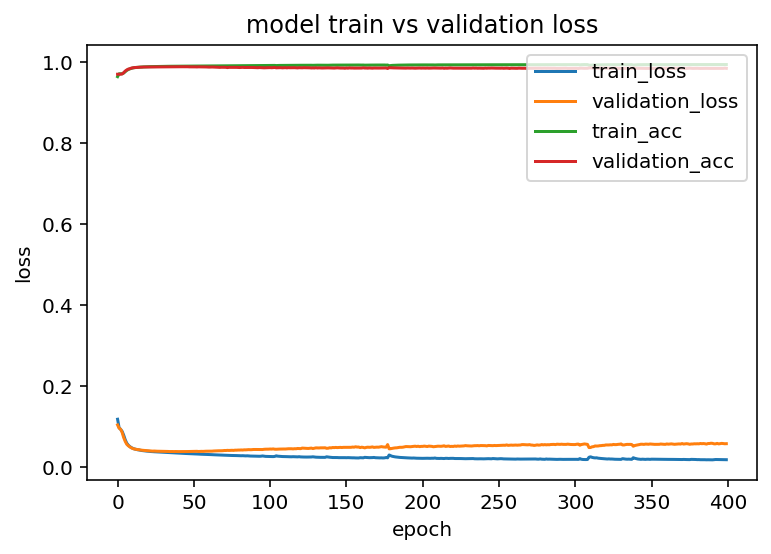

Result stored in ./output/train_multilabel_v3_2_16th_no_repeat_4001000_1606542398/


In [14]:
epochs = 400
batchsize = 1000

output_path = "./output/train_multilabel_v3_2_16th_no_repeat_{}{}_{}/".format(epochs,batchsize,int(time.time()))
os.mkdir(output_path)
weight_path = output_path + "music-gen-weight.hdf5"
checkpoint = ModelCheckpoint(
    weight_path,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint]
history = model.fit(network_input,
                    network_output, 
                    epochs=epochs, 
                    batch_size=batchsize, 
                    callbacks=callbacks_list,
                    validation_split=0.1,
                   shuffle=True)


  
train_loss += history.history['loss']
val_loss += history.history['val_loss']
# train_acc += history.history['accuracy']
# val_acc += history.history['val_accuracy']

plt.plot(train_loss)
plt.plot(val_loss)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss' ], loc='upper right')
plt.savefig(output_path + 'history.png')
plt.show()
print("Result stored in {}".format(output_path))

### Inference 

In [62]:
#choosing random index as my starting point, allows us to get different results everytime
start = np.random.randint(0, len(network_input)-1) 
# pattern = network_input[start]
invalid_pattern = mlb.transform([()]*50)
while (np.array_equal(network_input[start], invalid_pattern)):
    print(f"input is all empty, rerolling...")
    start = np.random.randint(0, len(network_input)-1) 

pattern = network_input[0]
ori = pattern.copy()

prediction_output = pattern.copy().tolist()
ori = pattern.copy()
# prediction_output.append(np.arange(0,10))
# sigmoid_output = 
# prediction_output = []

# int_to_note = dict((str(to_categorical(number, n_vocab)) , note) for number, note in enumerate(unique_note))

#create mapping funciton to decode output of network and map numerical data back to categorical data
# int_to_chord = dict((number, chord) for number, chord in enumerate(unique_chord_list))

for chord_index in range(1500): #here, we're generating 100 chords
    
    prediction_input = np.reshape(pattern, (1, len(pattern), n_features))
#     prediction_input = prediction_input / float(n_vocab)
    
    prediction = model.predict(prediction_input, verbose=0)
    
#     index = np.argmax(prediction)
    #map index back to note
#     result = int_to_note[index]
    result = np.where(prediction>0.5 , 1, 0)
    
    #add predicted note to my output
    prediction_output.append(result[0].tolist())
    
    #insert index of new note to the end of my pattern
    pattern = np.append(pattern,result, axis=0)

    
    #Remove the first note of my pattern
    pattern = pattern[1:len(pattern)]

In [63]:
mlb.inverse_transform(ori)

[(74,),
 (74,),
 (74,),
 (74,),
 (74,),
 (74,),
 (74,),
 (86,),
 (55, 86),
 (55, 86),
 (55, 86),
 (55, 86),
 (55, 86),
 (55, 86),
 (55, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 70, 86),
 (55, 58, 62, 69, 70, 86),
 (55, 58, 62, 69, 70, 86),
 (55, 58, 62, 69, 70, 86),
 (55, 58, 62, 69, 70, 74, 86),
 (55, 58, 62, 69, 70, 74, 86),
 (55, 58, 62, 69, 70, 74, 86),
 (55, 58, 62, 69, 70, 74, 86),
 (55, 58, 62, 69, 70, 74, 86),
 

In [64]:

mlb.inverse_transform(np.array(prediction_output))

[(74,),
 (74,),
 (74,),
 (74,),
 (74,),
 (74,),
 (74,),
 (86,),
 (55, 86),
 (55, 86),
 (55, 86),
 (55, 86),
 (55, 86),
 (55, 86),
 (55, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 86),
 (55, 58, 62, 69, 70, 86),
 (55, 58, 62, 69, 70, 86),
 (55, 58, 62, 69, 70, 86),
 (55, 58, 62, 69, 70, 86),
 (55, 58, 62, 69, 70, 74, 86),
 (55, 58, 62, 69, 70, 74, 86),
 (55, 58, 62, 69, 70, 74, 86),
 (55, 58, 62, 69, 70, 74, 86),
 (55, 58, 62, 69, 70, 74, 86),
 

In [65]:
def piano_roll_to_pretty_midi(piano_roll_in, fs, program=0, velocity = 64):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    piano_roll = np.where(piano_roll_in == 1, 64, 0)
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI(initial_tempo=100.0)
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')
    print(piano_roll.shape)
    
    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


## Saving inference result
Save inference result to file

In [66]:
output_path = f"../output/MusicLSTM3_survey_inference/"
# if output_path is not None:
#     os.mkdir(output_path)

bpm = 120
fs = 1/((60/bpm)/8)
idx = 1
mid_out = piano_roll_to_pretty_midi(np.array(prediction_output).T, fs=fs)
mid_ori = piano_roll_to_pretty_midi(np.array(ori).T, fs=fs)
midi_out_path = output_path+f"AlmostBlue_lstm2.mid"
if midi_out_path is not None:
        mid_out.write(midi_out_path)
        
midi_ori_path = output_path+f"ori_SmallDay_lstm3.mid"
if midi_ori_path is not None:
        mid_ori.write(midi_ori_path)

(128, 1602)
(128, 102)
